# Tiling 888, Alpha was further tunes, 300 Episodes #

Best version was already fast, but not fast enough. Next try is with bigger alpha in the beginning

parameters: 

alpha:
        if episode < 25:
            return 0.65
        elif episode < 35:
            return 0.6
        elif episode < 45:
            return 0.55
        elif episode < 55:
            return 0.5
        else:
            return 0.4

gamma: 
        max(1.0-episode/200, 0.5)
        
epsilon:
        max(0.1-episode/200, 0.001)
        



In [1]:
import gym
import os
import numpy as np
os.environ["DISPLAY"] = ":0"

nbEpisodes=1
nbTimesteps=50
env = gym.make('MountainCar-v0')

class tileModel:
    def __init__(self, nbTilings, gridSize):
        # characteristica of observation
        self.obsHigh = env.observation_space.high
        self.obsLow = env.observation_space.low
        self.obsDim = len(self.obsHigh)
        
        # characteristica of tile model
        self.nbTilings = nbTilings
        self.gridSize = gridSize
        self.gridWidth = np.divide(np.subtract(self.obsHigh,self.obsLow), self.gridSize)
        self.nbTiles = (self.gridSize**self.obsDim) * self.nbTilings
        self.nbTilesExtra = (self.gridSize**self.obsDim) * (self.nbTilings+1)
        
        #state space
        self.nbActions = env.action_space.n
        self.resetStates()
        
    def resetStates(self):
        ### funktioniert nicht, auch nicht mit -10 self.states = np.random.uniform(low=10.5, high=-11.0, size=(self.nbTilesExtra,self.nbActions))
        self.states = np.random.uniform(low=0.0, high=0.0001, size=(self.nbTilesExtra,self.nbActions))
        ### self.states = np.zeros([self.nbTiles,self.nbActions])
        
        
    def displayM(self):
        print('observation:\thigh:', self.obsHigh, 'low:', self.obsLow, 'dim:',self.obsDim )
        print('tile model:\tnbTilings:', self.nbTilings, 'gridSize:',self.gridSize, 'gridWidth:',self.gridWidth,'nb tiles:', self.nbTiles )
        print('state space:\tnb of actions:', self.nbActions, 'size of state space:', self.nbTiles)
        
    def code (self, obsOrig):
        #shift the original observation to range [0, obsHigh-obsLow]
        #scale it to the external grid size: if grid is 8*8, each range is [0,8]
        obsScaled = np.divide(np.subtract(obsOrig,self.obsLow),self.gridWidth)
        ### print ('\noriginal obs:',obsOrig,'shifted and scaled obs:', obsScaled )
        
        #compute the coordinates/tiling
        #each tiling is shifted by tiling/gridSize, i.e. tiling*1/8 for grid 8*8
        #and casted to integer
        coordinates = np.zeros([self.nbTilings,self.obsDim])
        tileIndices = np.zeros(self.nbTilings)
        for tiling in range(self.nbTilings):
            coordinates[tiling,:] = obsScaled + tiling/ self.nbTilings
        coordinates=np.floor(coordinates)
        
        #this coordinates should be used to adress a 1-dimensional status array
        #for 8 tilings of 8*8 grid we use:
        #for tiling 0: 0-63, for tiling 1: 64-127,...
        coordinatesOrg=np.array(coordinates, copy=True)        
        ### print ('coordinates:', coordinates)
        
        for dim in range(1,self.obsDim):
            coordinates[:,dim] *= self.gridSize**dim
        ### print ('coordinates:', coordinates)
        condTrace=False
        for tiling in range(self.nbTilings):
            tileIndices[tiling] = (tiling * (self.gridSize**self.obsDim) \
                                   + sum(coordinates[tiling,:])) 
            if tileIndices[tiling] >= self.nbTilesExtra:
                condTrace=True
                
        if condTrace:
            print("code: obsOrig:",obsOrig, 'obsScaled:', obsScaled, "coordinates w/o shift:\n", coordinatesOrg )
            print ("coordinates multiplied with base:\n", coordinates, "\ntileIndices:", tileIndices)
        ### print ('tileIndices:', tileIndices)
        ### print ('coordinates-org:', coordinatesOrg)
        return coordinatesOrg, tileIndices
    
    def getQ(self,state):
        Q=np.zeros(self.nbActions)
        _,tileIndices=self.code(state)
        ### print ('getQ-in : state',state,'tileIndices:', tileIndices)

        for i in range(len(tileIndices)):
            index=int(tileIndices[i])
            Q=np.add(Q,self.states[index])
        ### print ('getQ-out : Q',Q)
        Q=np.divide(Q,self.nbTilings)
        return Q
    
    def updateQ(self, state, action, deltaQA):
        _,tileIndices=self.code(state)
        ### print ('updateQ-in : state',state,'tileIndices:', tileIndices,'action:', action, 'deltaQA:', deltaQA)

        for i in range(len(tileIndices)):
            index=int(tileIndices[i])
            self.states[index,action]+=deltaQA
            ### print ('updateQ: index:', index, 'states[index]:',self.states[index])
            
    def preparePlot(self):
        plotInput=np.zeros([self.gridSize*self.nbTilings, self.gridSize*self.nbTilings,self.nbActions])    #pos*velo*actions
        iTiling=0
        iDim1=0                 #velocity
        iDim0=0                 #position
        ### tileShift=1/self.nbTilings
        
        for i in range(self.nbTiles):
            ### print ('i:',i,'iTiling:',iTiling,'iDim0:',iDim0, 'iDim1:', iDim1 ,'state:', self.states[i])
            for jDim0 in range(iDim0*self.nbTilings-iTiling, (iDim0+1)*self.nbTilings-iTiling):
                for jDim1 in range(iDim1*self.nbTilings-iTiling, (iDim1+1)*self.nbTilings-iTiling):
                    ### print ('iTiling:',iTiling,'jDim0:', jDim0, 'jDim1:', jDim1, 'state before:', plotInput[jDim0,jDim1] )
                    if jDim0>0 and jDim1 >0:
                        plotInput[jDim0,jDim1]+=self.states[i]
                        ### print ('iTiling:',iTiling,'jDim0:', jDim0, 'jDim1:', jDim1, 'state after:', plotInput[jDim0,jDim1] )
            iDim0+=1
            if iDim0 >= self.gridSize:
                iDim1 +=1
                iDim0 =0
            if iDim1 >= self.gridSize:
                iTiling +=1
                iDim0=0
                iDim1=0
        return plotInput
        
        
            

    

[2017-05-31 13:31:15,440] Making new env: MountainCar-v0


In [2]:
tileModel  = tileModel(8,8)                     #grid: 8*8, 8 tilings
tileModel.displayM()


observation:	high: [ 0.6   0.07] low: [-1.2  -0.07] dim: 2
tile model:	nbTilings: 8 gridSize: 8 gridWidth: [ 0.225   0.0175] nb tiles: 512
state space:	nb of actions: 3 size of state space: 512


In [3]:
nbEpisodes = 300
nbTimesteps = 200
alpha = 0.5
gamma = 0.9
epsilon = 0.01
EpisodesEvaluated=100
rewardLimit=-110

strategyEpsilon=4           #0: 1/episode**2, 1:1/episode, 2: (1/2)**episode 3: 0.01 4: linear 9:0.1
IntervalEpsilon=200
BaseEpsilon=0.001
StartEpsilon=0.1

strategyGamma=4
IntervalGamma=200
BaseGamma=0.5

strategyAlpha=6

policySARSA=True
printEpisodeResult=False


Episode 0 done after 200 steps, reward Average: -200.0, up to now: minReward: -200, minAverage: -200
Episode 1 done after 200 steps, reward Average: -200.0, up to now: minReward: -200, minAverage: -200
Episode 2 done after 200 steps, reward Average: -200.0, up to now: minReward: -200, minAverage: -200
Episode 3 done after 200 steps, reward Average: -200.0, up to now: minReward: -200, minAverage: -200
Episode 4 done after 200 steps, reward Average: -200.0, up to now: minReward: -200, minAverage: -200
Episode 5 done after 200 steps, reward Average: -200.0, up to now: minReward: -200, minAverage: -200
Episode 6 done after 200 steps, reward Average: -200.0, up to now: minReward: -200, minAverage: -200
Episode 7 done after 200 steps, reward Average: -200.0, up to now: minReward: -200, minAverage: -200
Episode 8 done after 200 steps, reward Average: -200.0, up to now: minReward: -200, minAverage: -200
Episode 9 done after 200 steps, reward Average: -200.0, up to now: minReward: -200, minAver

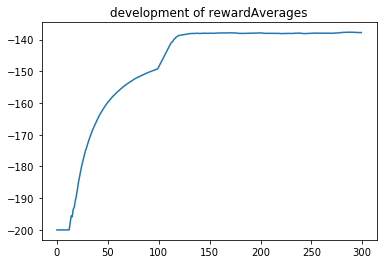

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random as random
### from matplotlib import colors as mcolors
### colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

def policy(Q,epsilon):    
    if epsilon>0.0 and random.random() < epsilon:
        return env.action_space.sample()
    else: 
        return np.argmax(Q) 

def decayFunction(episode, strategy=0, decayInterval=100, decayBase=0.5, decayStart=1.0):
    global nbEpisodes
    if strategy==0:
        return 1/((episode+1)**2)
    elif strategy ==1:
        return 1/(episode+1)
    elif strategy ==2:
        return (0.5)**episode
    elif strategy ==3:
        return 0.05
    elif strategy ==4:
        return max(decayStart-episode/decayInterval, decayBase)
    elif strategy ==5:
        return 0.5*(0.5**episode)+0.5
    elif strategy ==6:
        if episode < 25:
            return 0.65
        elif episode < 35:
            return 0.6
        elif episode < 45:
            return 0.55
        elif episode < 55:
            return 0.5
        else:
            return 0.4
    else:
        return 0.1

lastDelta=-1000.0
colorplot=np.empty([tileModel.nbTilings*tileModel.gridSize,tileModel.nbTilings*tileModel.gridSize],dtype=str)
tileModel.resetStates()
arrivedNb=0
arrivedFirst=0

rewardTracker = np.zeros(EpisodesEvaluated)
rewardAverages=[]
problemSolved=False
rewardMin=-200
averageMin=-200


for episode in range(nbEpisodes):                    
    state = env.reset()
    rewardAccumulated =0
    epsilon=decayFunction(episode,strategy=strategyEpsilon,\
                          decayInterval=IntervalEpsilon, decayBase=BaseEpsilon,decayStart=StartEpsilon)
    gamma=decayFunction(episode,strategy=strategyGamma,decayInterval=IntervalGamma, decayBase=BaseGamma)
    alpha=decayFunction(episode,strategy=strategyAlpha)
    

    Q=tileModel.getQ(state)
    action = policy(Q,epsilon)
    ### print ('Q_all:', Q, 'action:', action, 'Q_action:',Q[action])

    deltaQAs=[0.0]
   
    for t in range(nbTimesteps):
        env.render()
        state_next, reward, done, info = env.step(action)
        rewardAccumulated+=reward
        ### print('\n--- step action:',action,'returns: reward:', reward, 'state_next:', state_next)
        if done:
            rewardTracker[episode%EpisodesEvaluated]=rewardAccumulated
            if episode>=EpisodesEvaluated:
                rewardAverage=np.mean(rewardTracker)
                if rewardAverage>=rewardLimit:
                    problemSolved=True
            else:
                rewardAverage=np.mean(rewardTracker[0:episode+1])
            rewardAverages.append(rewardAverage)
            
            if rewardAccumulated>rewardMin:
                rewardMin=rewardAccumulated
            if rewardAverage>averageMin:
                averageMin = rewardAverage
                
            print("Episode {} done after {} steps, reward Average: {}, up to now: minReward: {}, minAverage: {}"\
                  .format(episode, t+1, rewardAverage, rewardMin, averageMin))
            if t<nbTimesteps-1:
                ### print ("ARRIVED!!!!")
                arrivedNb+=1
                if arrivedFirst==0:
                    arrivedFirst=episode
            break
        #update Q(S,A)-Table according to:
        #Q(S,A) <- Q(S,A) + α (R + γ Q(S’, A’) – Q(S,A))
        
        #start with the information from the old state:
        #difference between Q(S,a) and actual reward
        #problem: reward belongs to state as whole (-1 for mountain car), Q[action] is the sum over several features
            
        #now we choose the next state/action pair:
        Q_next=tileModel.getQ(state_next)
        action_next=policy(Q_next,epsilon)
        action_QL=policy(Q_next,0.0)   

        if policySARSA:
            action_next_learning=action_next
        else:
            action_next_learning=action_QL

        
        # take into account the value of the next (Q(S',A') and update the tile model
        deltaQA=alpha*(reward + gamma * Q_next[action_next_learning] - Q[action])
        deltaQAs.append(deltaQA)
        
        ### print ('Q:', Q, 'action:', action, 'Q[action]:', Q[action])
        ### print ('Q_next:', Q_next, 'action_next:', action_next, 'Q_next[action_next]:', Q_next[action_next])
        ### print ('deltaQA:',deltaQA)
        tileModel.updateQ(state, action, deltaQA)
        ### print ('after update: Q:',tileModel.getQ(state))

        
        
        ###if lastDelta * deltaQA < 0:           #vorzeichenwechsel
        ###    print ('deltaQA in:alpha:', alpha,'reward:',reward,'gamma:',gamma,'action_next:', action_next,\
        ###           'Q_next[action_next]:',Q_next[action_next],'action:',action,'Q[action]:', Q[action],'deltaQA out:',deltaQA)
        ###lastDelta=deltaQA
        
        # prepare next round:
        state=state_next
        action=action_next
        Q=Q_next
               
    if printEpisodeResult:
        #evaluation of episode: development of deltaQA
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.plot(range(len(deltaQAs)),deltaQAs,'-')
        ax1.set_title("after episode:  {} - development of deltaQA".format(episode))
        plt.show()

        #evaluation of episode: states
        plotInput=tileModel.preparePlot()
        ### print ('states:', tileModel.states)
        ### print ('plotInput:', plotInput)
    
        fig = plt.figure()
        ax2 = fig.add_subplot(111, projection='3d')
    
        x=range(tileModel.nbTilings*tileModel.gridSize)
        y=range(tileModel.nbTilings*tileModel.gridSize)
        yUnscaled=y*tileModel.gridWidth[0]+tileModel.obsLow[0]
        xUnscaled=x*tileModel.gridWidth[1]+tileModel.obsLow[1]


        colors=['r','b','g']
        labels=['back','neutral','forward']
        for i in range(tileModel.nbActions):
            ax2.plot_wireframe(xUnscaled,yUnscaled,plotInput[x,y,i],color=colors[i],label=labels[i])

        ax2.set_xlabel('velocity')
        ax2.set_ylabel('position')
        ax2.set_zlabel('action')
        ax2.set_title("after episode:  {}".format(episode))
        ax2.legend()
        plt.show()

        #colorplot=np.empty([tileModel.nbTilings*tileModel.gridSize,tileModel.nbTilings*tileModel.gridSize],dtype=str)
        minVal=np.zeros(3)
        minCoo=np.empty([3,2])
        maxVal=np.zeros(3)
        maxCoo=np.empty([3,2])
        for ix in x:
            for iy in y:
                if 0.0 <= np.sum(plotInput[ix,iy,:]) and np.sum(plotInput[ix,iy,:])<=0.003:
                    colorplot[ix,iy]='g'
                elif colorplot[ix,iy]=='g':
                    colorplot[ix,iy]='blue'
                else:
                    colorplot[ix,iy]='cyan'
                

        xUnscaled=np.linspace(tileModel.obsLow[0], tileModel.obsHigh[0], num=tileModel.nbTilings*tileModel.gridSize)
        yUnscaled=np.linspace(tileModel.obsLow[1], tileModel.obsHigh[1], num=tileModel.nbTilings*tileModel.gridSize)

        fig = plt.figure()
        ax3 = fig.add_subplot(111)
    
        for i in x:
            ax3.scatter([i]*len(x),y,c=colorplot[i,y],s=75, alpha=0.5)

        #ax3.set_xticklabels(xUnscaled)
        #ax3.set_yticklabels(yUnscaled)
        ax3.set_xlabel('velocity')
        ax3.set_ylabel('position')
        ax3.set_title("after episode:  {} visited".format(episode))
        plt.show()
        
        if problemSolved:
            break

print('final result: \n{} times arrived in {} episodes, first time in episode {}\nproblem solved?:{}'.format(arrivedNb,nbEpisodes,arrivedFirst,problemSolved))
#evaluation of episode: development of deltaQA
fig = plt.figure()
ax4 = fig.add_subplot(111)
ax4.plot(range(len(rewardAverages)),rewardAverages,'-')
ax4.set_title("development of rewardAverages")
plt.show()
